Optimization terminated successfully.
         Current function value: 1.414214
         Iterations: 43
         Function evaluations: 159
Optimized t values: [0.21 0.4  0.6  0.8 ]


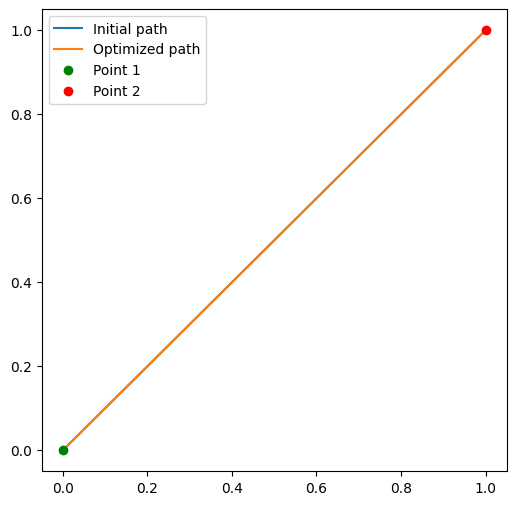

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 定义两个点
point1 = np.array([0, 0])
point2 = np.array([1, 1])

# 定义路径的参数表示，这里我们使用一个参数 t，代表从 point1 到 point2 的比例
def path(t):
    # 当 t 是一个数组时，我们需要对数组中的每个元素单独处理
    if isinstance(t, np.ndarray):
        return np.array([point1 * (1 - ti) + point2 * ti for ti in t])
    else:
        return point1 * (1 - t) + point2 * t

# 定义路径长度的函数，我们需要对这个函数进行优化
def path_length(t):
    # 将 t 分解成许多小段
    t_values = np.linspace(0, 1, len(t)+2)
    t_values[1:-1] = t

    # 计算路径上各点之间的距离
    distances = [np.linalg.norm(path(t_values[i+1]) - path(t_values[i])) for i in range(len(t_values)-1)]

    # 返回总距离
    return np.sum(distances)

# 初始的 t 值，我们选择五个点，即将路径分成四段
t_initial = np.array([0.2, 0.4, 0.6, 0.8])

# 使用 scipy 的 minimize 函数来求解优化问题
result = minimize(path_length, t_initial, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

# 打印结果
print("Optimized t values:", result.x)

# 绘制原始路径和优化后的路径
t_values = np.linspace(0, 1, 100)
plt.figure(figsize=(6, 6))
plt.plot(*path(t_values).T, label="Initial path")
plt.plot(*path(np.concatenate([[0], result.x, [1]])).T, label="Optimized path")
plt.plot(*point1, 'go', label="Point 1")
plt.plot(*point2, 'ro', label="Point 2")
plt.legend()
plt.show()


In [38]:
import numpy as np
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.stats import zscore

def arc_length_parametrize(curve):
    # 计算曲线上每两个连续点之间的距离
    diffs = np.diff(curve, axis=0)
    segment_lengths = np.sqrt((diffs**2).sum(axis=1))

    # 累加这些距离得到每个点的弧长
    arc_lengths = np.concatenate([[0], np.cumsum(segment_lengths)])

    # 生成新的参数值（等间距）
    num_points = len(curve)
    new_params = np.linspace(0, arc_lengths[-1], num_points)

    # 对曲线的每一个维度进行插值
    new_curve = np.zeros_like(curve)
    for i in range(3):
        interp = interp1d(arc_lengths, curve[:, i], kind='cubic')
        new_curve[:, i] = interp(new_params)

    return new_curve

def calculate_srvf(curve):
    # 计算曲线的导数
    t = np.linspace(0, 1, curve.shape[0])
    cs = CubicSpline(t, curve)
    derivative = cs(t, 1)
    
    # 计算SRVF
    magnitude = np.linalg.norm(derivative, axis=1)
    srvf = np.sqrt(magnitude)[:, np.newaxis] * derivative / magnitude[:, np.newaxis]

    return srvf

def align_curve(curve):
    # 将曲线平移到原点
    # print ("debug align_curve")
    # print ("curve.shape:", curve.shape)
    curve_centered = curve - np.mean(curve, axis=0)

    # Reshape the centered curve into 2D array
    curve_centered_2d = curve_centered.reshape(-1, curve_centered.shape[1]*curve_centered.shape[2])

    # 计算PCA
    pca = PCA(n_components=30)
    curve_pca = pca.fit_transform(curve_centered_2d)
    curve_pca = pca.inverse_transform(curve_pca)
    # print ("curve_pca.shape:", curve_pca.shape)

    # reshape back to the original shape
    curve_pca = curve_pca.reshape(curve_centered.shape)

    return curve_pca



In [228]:
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import numpy as np
import pandas as pd

ill=pd.read_csv("./illcases.txt",header=None)
ill = np.array(ill[0])
print (ill)
pre_files = glob.glob("./scaling/resamp_attr_ascii/vmtk64a/*.vtk")
curves = []
files = []
radii = []
curvatures = []
for idx in range(len(pre_files)):
    filename = pre_files[idx].split("\\")[-1].split(".")[0][:-8]
    if filename in ill:
        print (filename, "is found in illcases.txt, skip")
        continue
    # print (filename)
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent, fnormal, fbinormal = GetMyVtk(pre_files[idx], frenet=1)
    files.append(pre_files[idx])
    curves.append(pt)
    radii.append(Radius)
    curvatures.append(Curv)

curves = np.array(curves)
radii = np.array(radii)
curvatures = np.array(curvatures)
print (curves.shape)
print (radii.shape)

for i in range(len(files)):
    if "BH0017_R" in files[i]:
        base_id = i

print ("base_id:", base_id)
print (files[base_id])

['BH0004_Left' 'BH0004_Right' 'BH00008_Left' 'BH00008_Right' 'BH0032_Left'
 'BH0032_Right' 'BG0002_Right' 'BG0002_Left' 'BH0002_Right' 'BH0002_Left'
 'BH0008_Right' 'BH0008_Left']
BG0002_Left is found in illcases.txt, skip
BG0002_Right is found in illcases.txt, skip
BH0002_Left is found in illcases.txt, skip
BH0002_Right is found in illcases.txt, skip
BH0004_Left is found in illcases.txt, skip
BH0004_Right is found in illcases.txt, skip
BH0008_Left is found in illcases.txt, skip
BH0008_Right is found in illcases.txt, skip
BH0032_Left is found in illcases.txt, skip
BH0032_Right is found in illcases.txt, skip
(94, 64, 3)
(94, 64)
base_id: 49
./scaling/resamp_attr_ascii/vmtk64a\BH0017_Right_new_new.vtk


(94, 64, 3)


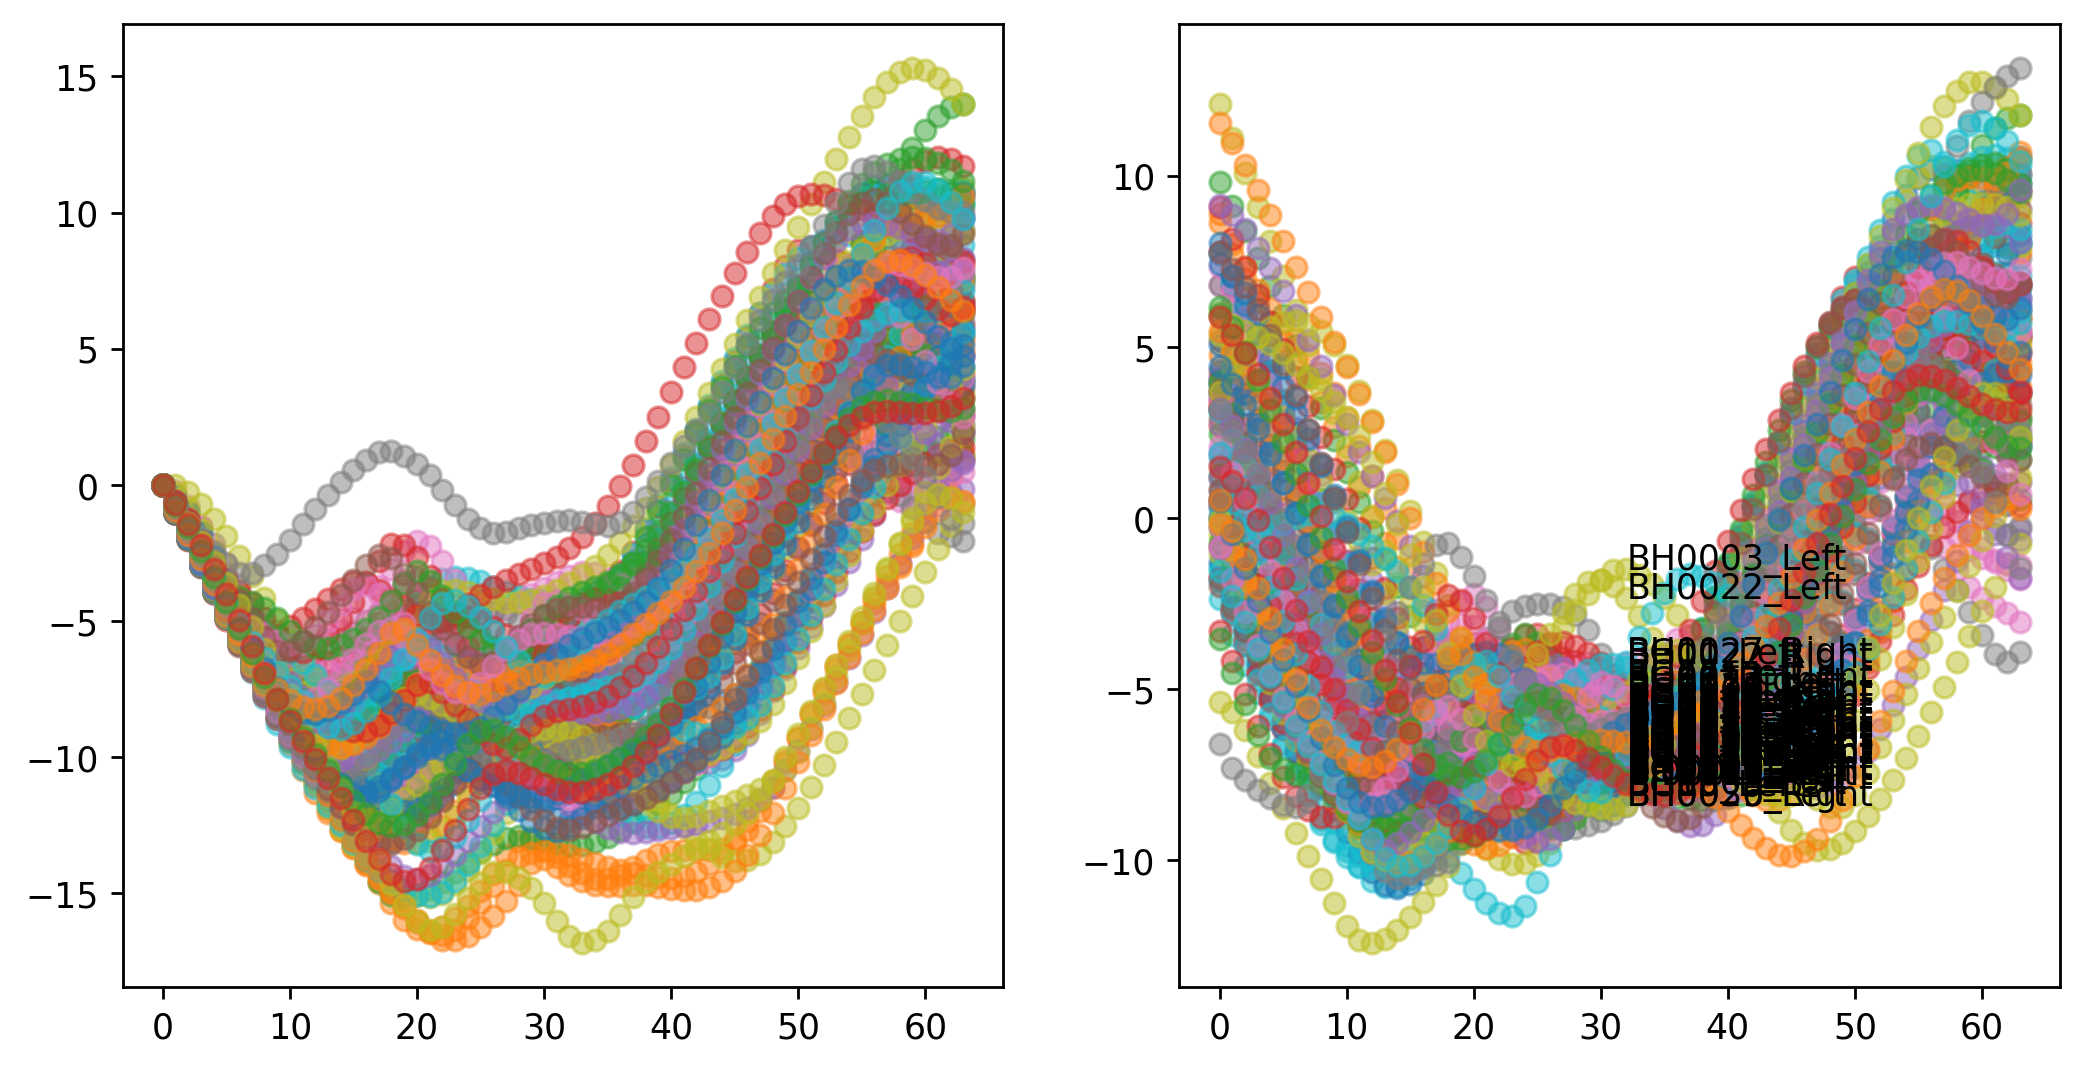

In [229]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def align_icp(curves,base_id=80):
    # 使用第一条曲线作为基准曲线
    new_curves = []
    base_curve = curves[base_id]
    
    for i in range(len(curves)):
        curve = curves[i]
        
        # 计算基准曲线和当前曲线的质心
        base_centroid = np.mean(base_curve, axis=0)
        curve_centroid = np.mean(curve, axis=0)
        
        # 将两个曲线移到原点
        base_centered = base_curve - base_centroid
        curve_centered = curve - curve_centroid
        
        # 计算最优旋转
        H = np.dot(base_centered.T, curve_centered)
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        
        if np.linalg.det(R) < 0:
           Vt[-1,:] *= -1
           R = np.dot(Vt.T, U.T)
        
        # 旋转和平移当前曲线以对齐到基准曲线
        # curves[i] = np.dot((curve - curve_centroid), R.T) + base_centroid
        new_curves.append(np.dot((curve - curve_centroid), R.T) + base_centroid)

    return np.array(new_curves)


a_curves = align_icp(curves, base_id=base_id)
print (a_curves.shape)
fig = plt.figure(figsize=(10, 5),dpi=250)
ax = fig.add_subplot(121) 
ax2 =fig.add_subplot(122) 
for i in range(len(a_curves)):
    filename=files[i].split("\\")[-1].split(".")[0][:-8]
    # print (filename)
    curve = curves[i]
    a_curve = a_curves[i]

    ax.plot(curve[:,0], 'o', label='original points', alpha=0.5)
    ax2.plot(a_curve[:,0], 'o', label='align points', alpha=0.5)
    ax2.text(32,a_curve[:,0][32],str(filename))

# Procrustes

p_curve.shape: (94, 64, 3)


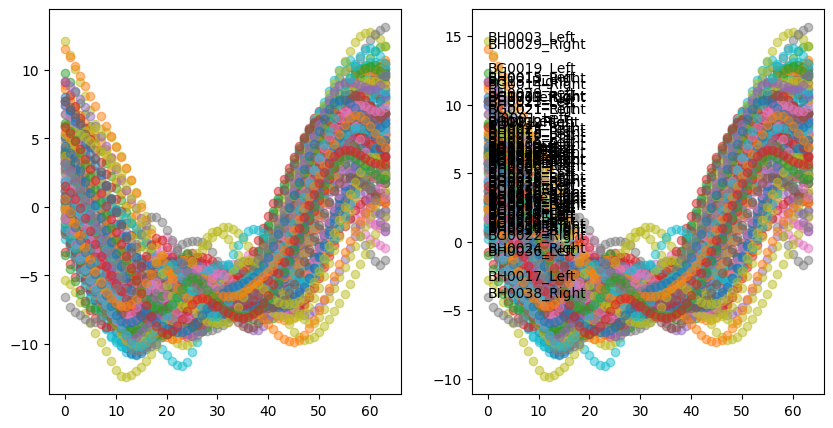

In [230]:
from procrustes import orthogonal

def align_procrustes(curves,base_id=0):
    # 使用第一条曲线作为基准曲线
    base_curve = curves[base_id]
    new_curves = []
    
    for i in range(len(curves)):
        curve = curves[i]
        # print (orthogonal(base_curve, curve, translate=True, scale=True))
        # 对齐当前曲线到基准曲线
        result = orthogonal(base_curve, curve, translate=True, scale=False)
    
        # Z是Procrustes变换后的曲线，用它来更新原始曲线
        # curves[i] = Z
        new_curves.append(result['new_b'])

    return np.array(new_curves)


p_curves = align_procrustes(a_curves,base_id=base_id)

print ("p_curve.shape:", p_curves.shape)

fig = plt.figure(figsize=(10, 5),dpi=100)
ax = fig.add_subplot(121) 
ax2 =fig.add_subplot(122) 
coord_id = 0
for i in range(len(a_curves)):
    filename=files[i].split("\\")[-1].split(".")[0][:-8]
    # print (filename)
    p_curve = p_curves[i]
    a_curve = a_curves[i]

    ax.plot(a_curve[:,coord_id], 'o', label='original points', alpha=0.5)
    ax2.plot(p_curve[:,coord_id], 'o', label='align points', alpha=0.5)
    ax2.text(0,p_curve[:,coord_id][0], str(filename))


In [271]:
curves = p_curves

# interpolation

94


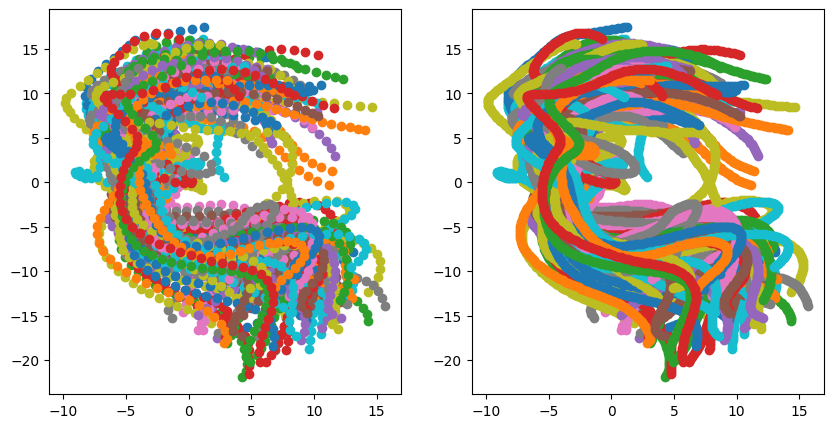

In [273]:
from scipy import interpolate
interpolated_curves = []
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121) 
ax2 =fig.add_subplot(122) 
for i in range(len(p_curves)):
    curve = p_curves[i]
    max_pt_length = 64*4
    x = np.linspace(0, len(curve), len(curve))
    z2 = np.linspace(0,len(curve), max_pt_length)
    c_interpolation = interpolate.CubicSpline(x, curve)
    curve2 = c_interpolation(z2)
    ax.plot(curve[:,0], curve[:,1], 'o', label='original points')
    ax2.plot(curve2[:,0], curve2[:,1], 'o', label='interpolation points')
    interpolated_curves.append(curve2)


print (len(interpolated_curves))

# SRVF process

align_curve shape: (94, 256, 3)
(94, 256, 3)


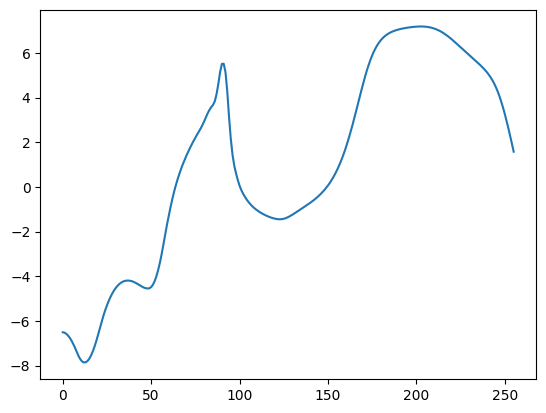

In [274]:
parametrized_curves = np.zeros_like(interpolated_curves)
# aligned_curves = np.zeros_like(interpolated_curves)
srvf_curves = np.zeros_like(interpolated_curves)
for i in range(len(interpolated_curves)):
    parametrized_curves[i] = arc_length_parametrize(interpolated_curves[i])

aligned_curves = align_curve(parametrized_curves)
print ("align_curve shape:", aligned_curves.shape)

for i in range(len(interpolated_curves)):
    # srvf_curves[i] = calculate_srvf(aligned_curves[i])
    srvf_curves[i] = calculate_srvf(interpolated_curves[i])

# x_mean = np.mean(srvf_curves[:,:,0])
# x_std = np.std(srvf_curves[:,:,0])
# y_mean = np.mean(srvf_curves[:,:,1])
# y_std = np.std(srvf_curves[:,:,1])
# z_mean = np.mean(srvf_curves[:,:,2])
# z_std = np.std(srvf_curves[:,:,2])

# srvf_curves[:,:,0] = zscore(srvf_curves[:,:,0],axis=0)
# srvf_curves[:,:,1] = zscore(srvf_curves[:,:,1],axis=0)
# srvf_curves[:,:,2] = zscore(srvf_curves[:,:,2],axis=0)


for i in range(1):
    plt.plot(srvf_curves[i][:, 0], label="Curve 1")

print (srvf_curves.shape)

最大方差方向: [-0.95324651 -0.09150614 -0.28800644]
投影后的数据形状: (94, 256)


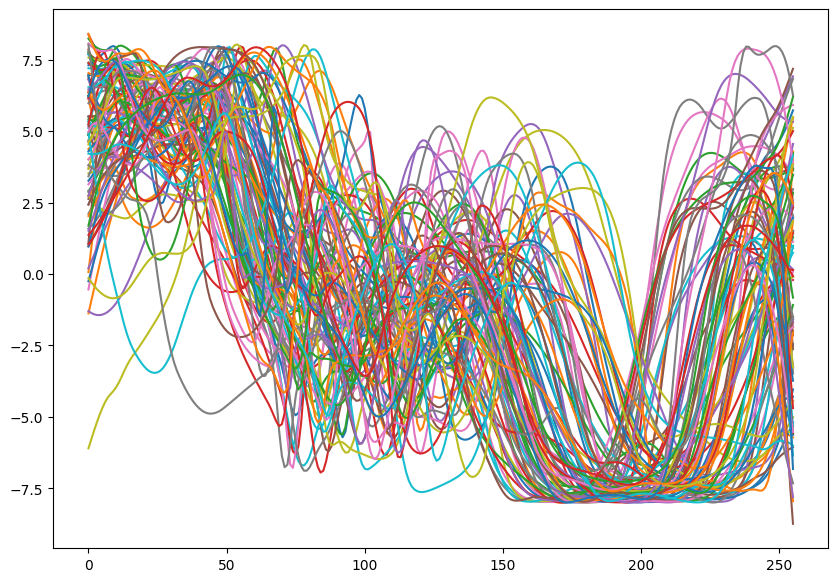

In [275]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设你的数据集存在于变量"data"中
data = srvf_curves 

# 调整数据形状以进行PCA
n_curves, n_points, n_dims = data.shape
data_reshaped = data.reshape(n_curves * n_points, n_dims)

# 执行PCA
pca = PCA(n_components=1)
pca.fit(data_reshaped)

# 找到最大方差方向
max_var_direction = pca.components_[0]
print("最大方差方向:", max_var_direction)

# 投影所有曲线到最大方差的方向上
data_projected = np.dot(data, max_var_direction)

print("投影后的数据形状:", data_projected.shape)

# 在最大方差的方向上绘制所有曲线
plt.figure(figsize=(10, 7))
for i in range(n_curves):
    plt.plot(data_projected[i], label=f'Curve {i+1}')
# plt.legend()
plt.show()


In [235]:
import geomstats.geometry.pre_shape as pre_shape
import numpy as np

# Assuming you have two curves A and B in SRVF representation
curve_A = srvf_curves[0]
curve_B = srvf_curves[16]

# Define the pre-shape space
# Here, 3 is the embedding dimension and 64 is the number of points on the curves
points_num=srvf_curves.shape[1]
pre_shape_space = pre_shape.PreShapeSpace(points_num, 3)
pre_shape_space.metric = pre_shape.PreShapeMetric(3, points_num)

# Compute the geodesic distance between the two SRVF curves
geodesic_distance = pre_shape_space.metric.dist(curve_A, curve_B)

print("The geodesic distance between the two curves is: ", geodesic_distance)


The geodesic distance between the two curves is:  124.58146225939538


(256,)


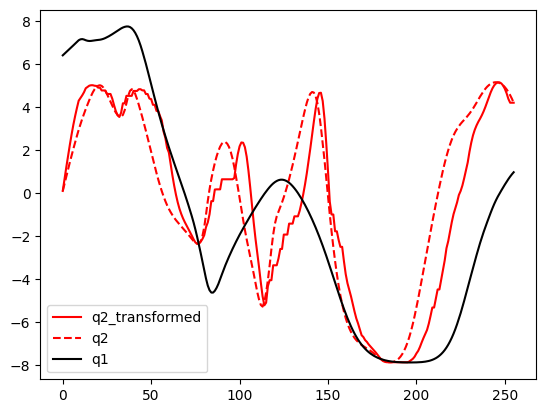

In [236]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from dtw import dtw


# 初始化q1和q2
q1 = srvf_curves[base_id]
q2 = srvf_curves[16]

# 定义Fisher-Rao距离
def fisher_rao_distance(q1, q2):
    return np.sqrt(np.sum((q1-q2)**2))

# 计算q1和q2之间的DTW距离和扭曲路径
alignment = dtw(q1, q2, keep_internals=True)

# 我们将扭曲路径作为时间变换函数gamma
gamma = alignment.index2

t = np.linspace(0, 1, q2.shape[0])
q2_transformed = interp1d(np.linspace(0, 1, len(gamma)), q2[gamma], axis=0)(t)

print (np.dot(q2_transformed, max_var_direction).shape)

plt.plot(np.dot(q2_transformed, max_var_direction), label="q2_transformed",color="red")
plt.plot(np.dot(q2, max_var_direction), label="q2",color="red",linestyle="--")
plt.plot(np.dot(q1, max_var_direction), label="q1",color="black")
plt.legend()

./scaling/resamp_attr_ascii/vmtk64a\BH0017_Right_new_new.vtk


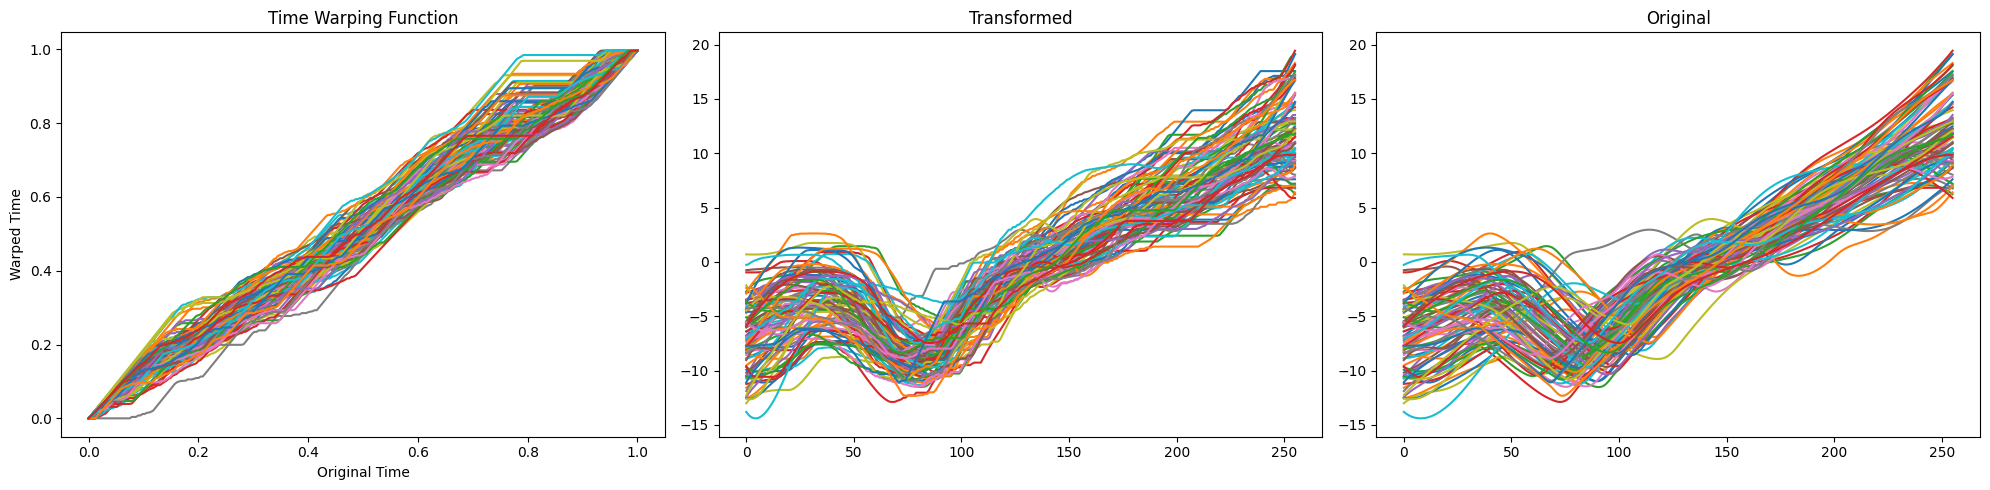

In [279]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtw import dtw
from myvtk.General import mkdir

select = base_id
print (files[select])

gammas = []
q2ts = []
q1 = srvf_curves[select]
flatten_q2ts = []
# 绘制时间变换函数
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for i in range(len(srvf_curves)):
    q2 = srvf_curves[i]
    # 计算q1和q2之间的DTW距离和扭曲路径
    alignment = dtw(q1, q2, keep_internals=True)

    # 我们将扭曲路径作为时间变换函数gamma
    gamma = alignment.index2
    # 对gamma进行归一化
    gamma_normalized = gamma / len(q1)
    # 对q2进行插值，得到变换后的曲线
    t = np.linspace(0, 1, len(gamma_normalized))
    # q2_transformed = interp1d(t, q2[gamma], axis=0)(t)
    q2_transformed = interp1d(t, interpolated_curves[i][gamma], axis=0)(t)

    # 创建一个新的插值函数，该函数接受范围为[0,1]的输入，输出q2_transformed中的对应点
    interp_fn = interp1d(np.linspace(0, 1, len(q2_transformed)), q2_transformed, axis=0)

    # 使用这个插值函数得到和q1相同长度的q2
    q2_resampled = interp_fn(np.linspace(0, 1, len(q1)))
    # 插值 gamma 使其在 [0,1] 范围内有 64 个点
    t_original = np.linspace(0, 1, q2.shape[0])
    gamma_interp = interp1d(t, gamma_normalized, fill_value="extrapolate")(t_original)


    gammas.append(gamma_interp)
    q2ts.append(q2_transformed)
    flatten_q2ts.extend(q2_transformed)

    ax1.plot(t_original, gamma_interp)
    # ax2.plot(np.dot(q2_resampled, max_var_direction_q2ts), label="q2_transformed")
    # ax3.plot(np.dot(interpolated_curves[i], max_var_direction), label="q2")
    ax2.plot(q2_resampled[:,2], label="q2_transformed")
    ax3.plot(interpolated_curves[i][:,2], label="q2")
ax1.set_xlabel('Original Time')
ax1.set_ylabel('Warped Time')
ax1.set_title('Time Warping Function')
# ax2.set_xlabel('Transformed')
# ax2.set_ylabel('Warped Time')
ax2.set_title('Transformed')
# ax3.set_xlabel('Original Time')
# ax3.set_ylabel('Warped Time')
ax3.set_title('Original')
plt.tight_layout()
plt.show()

flatten_q2ts = np.array(flatten_q2ts)

(94, 256)


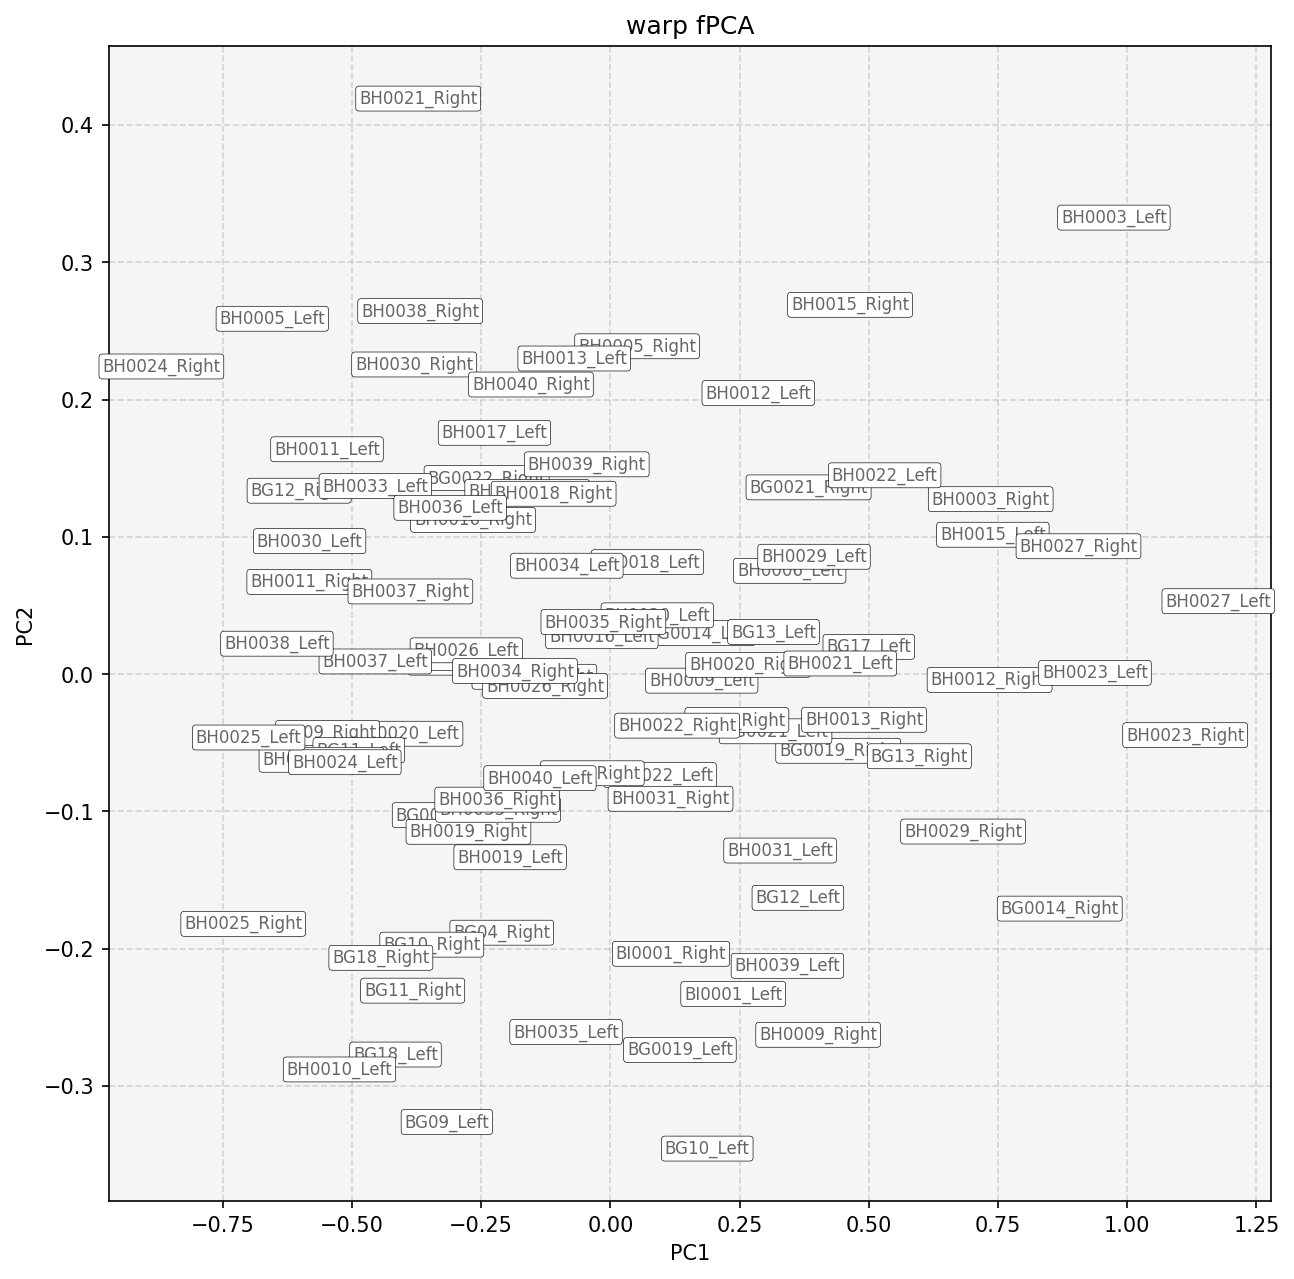

In [263]:
gammas = np.array(gammas)
print (gammas.shape)

pca = PCA(n_components=2)

# 对数据集进行 PCA 处理
gammas_pca = pca.fit_transform((gammas))


fig = plt.figure(figsize=(10, 10),dpi=150)
ax = fig.add_subplot(111)
ax.scatter(gammas_pca[:, 0], gammas_pca[:, 1],color="dimgray",edgecolors="white")
ax.scatter(gammas_pca[base_id, 0], gammas_pca[base_id, 1],color="darkorange")
for i in range(len(files)):
    filename=files[i].split("\\")[-1].split(".")[0][:-8]
    ax.text(gammas_pca[i, 0], gammas_pca[i, 1], filename,fontsize=8,alpha=0.6,
            ha="center", va="center",
                bbox=dict(facecolor="white",
                     #facecolor=quadra_color[target.lower()], 
                     linewidth=0.3, edgecolor="black", 
                     boxstyle='round,pad=0.2', alpha=1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
# ax.set_ylim(-2,2)
# ax.set_xlim(-2,2)
ax.set_title('warp fPCA')
ax.grid(linestyle="--",alpha=0.5)
ax.set_facecolor("whitesmoke")

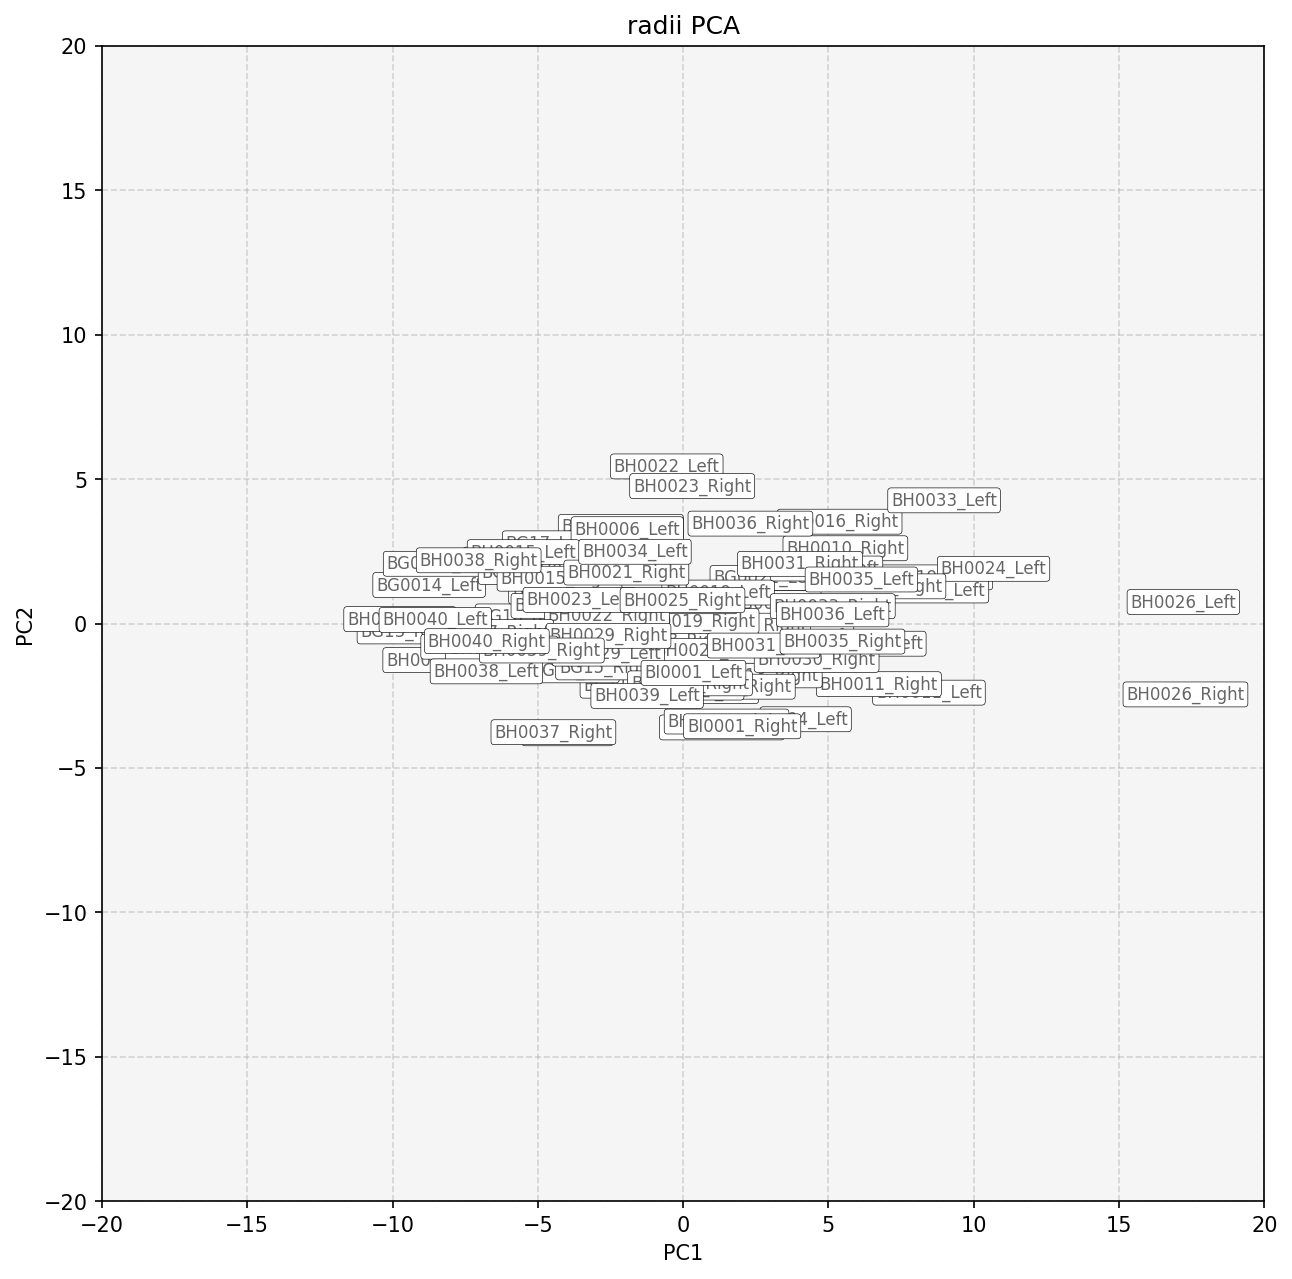

In [241]:
pca = PCA(n_components=2)

# 对数据集进行 PCA 处理
radii_pca = pca.fit_transform(zscore(radii,axis=0))


fig = plt.figure(figsize=(10, 10),dpi=150)
ax = fig.add_subplot(111)
ax.scatter(radii_pca[:, 0], radii_pca[:, 1],color="dimgray",edgecolors="white")
ax.scatter(radii_pca[base_id, 0], radii_pca[base_id, 1],color="darkorange")
for i in range(len(files)):
    filename=files[i].split("\\")[-1].split(".")[0][:-8]
    ax.text(radii_pca[i, 0], radii_pca[i, 1], filename,fontsize=8,alpha=0.6,
            ha="center", va="center",
                bbox=dict(facecolor="white",
                     #facecolor=quadra_color[target.lower()], 
                     linewidth=0.3, edgecolor="black", 
                     boxstyle='round,pad=0.2', alpha=1))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_ylim(-20,20)
ax.set_xlim(-20,20)
ax.set_title('radii PCA')
ax.grid(linestyle="--",alpha=0.5)
ax.set_facecolor("whitesmoke")

最大方差方向: [-0.84748239 -0.30968334 -0.43112623]


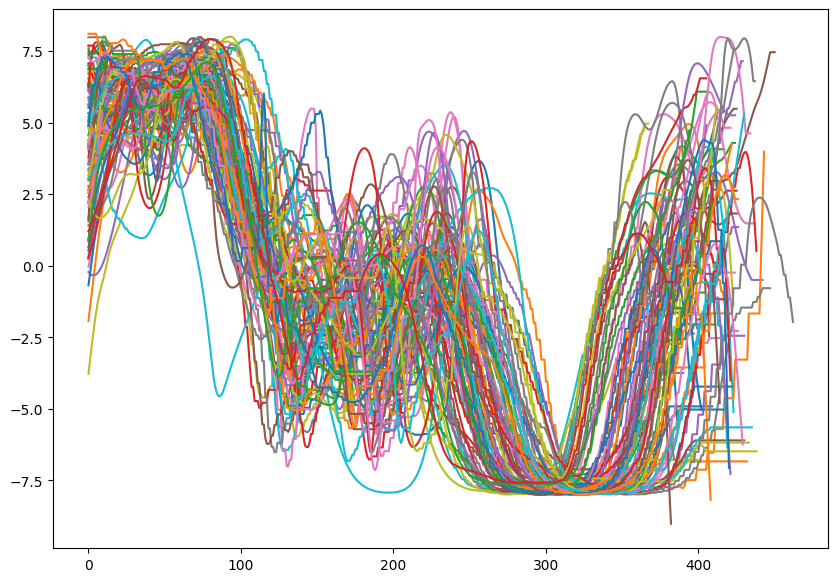

In [264]:
# 检查q2ts在哪个方向上方差最大
# 需要考虑曲率，则要在faltten_q2ts上加上一个curvature的维度

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data_reshaped = flatten_q2ts

# 执行PCA
pca = PCA(n_components=1)
pca.fit(data_reshaped)

# 找到最大方差方向
max_var_direction_q2ts = pca.components_[0]
print("最大方差方向:", max_var_direction_q2ts)

# 投影所有曲线到最大方差的方向上


# 在最大方差的方向上绘制所有曲线
plt.figure(figsize=(10, 7))
for i in range(len(q2ts)):
    data_projected = np.dot(q2ts[i], max_var_direction_q2ts)
    plt.plot(data_projected, label=f'Curve {i+1}')
# plt.legend()
plt.show()

